In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question-1

In [2]:
import matplotlib.pyplot as plt
from typing import List, Tuple
import math
import numpy as np

class SmartPlot:
    @staticmethod
    def plot_single_image(image,
                          title,
                          colorbar=False):
        plt.imshow(image)
        plt.title(title)
        if colorbar:
            plt.colorbar()
        plt.show()
    
    @staticmethod
    def get_dimensions(N):
        sqrt = round(math.sqrt(N))
        if sqrt * sqrt == N:
            return (sqrt, sqrt)
        for m in range(5, 0, -1):
            if N % m == 0:
                return (N//m, m)
    
    @classmethod
    def plot_multi_images(cls,
                          images: List,
                          figsize: Tuple[int, int],
                          titles: List | None = None,
                          axis: List | str = 'on',
                          cmaps: List | str = 'viridis',
                          suptitle: str | None = None,
                          dimensions: Tuple[int, int] | None = None,
                          colorbar: bool | List[bool] = False,
                          return_fig_axis: bool = False
                          ):
        num_images = len(images)
        if titles is None:
            titles = [None] * num_images
        if dimensions is None:
            dimensions = cls.get_dimensions(num_images)
        if type(colorbar) is bool:
            colorbar = [colorbar] * num_images
        if type(axis) is str:
            axis = [axis] * num_images
        if type(cmaps) is str:
            cmaps = [cmaps] * num_images

        fig, ax = plt.subplots(*dimensions, figsize=figsize)
        ax = np.array(ax).flatten()

        for i, (img, title, cbar) in enumerate(zip(images, titles, colorbar)):
            t = ax[i].imshow(img, cmap=cmaps[i])
            if title:
                ax[i].set_title(title)
            if cbar:
                plt.colorbar(t)
            ax[i].axis(axis[i])
        
        if suptitle:
            fig.suptitle(suptitle)
        if return_fig_axis:
            return fig, ax
        else:
            plt.show()


In [3]:
class Convolutions:
    @staticmethod
    def circular_convolution(image1, image2):
        n1, m1 = image1.shape
        n2, m2 = image2.shape
        out = np.zeros_like(image1, dtype=float)
        for i in range(n1):
            for j in range(m1):
                for k in range(n2):
                    for l in range(m2):
                        out[i, j] += image1[(i-k)%n1, (j-l)%m1] * image2[k, l]
        return out
    
    @staticmethod
    def pad_for_linear_convolution(image1, image2):
        n, m = image1.shape
        out1 = np.zeros((2*n, 2*m))
        out1[:n, :m] = image1

        n2, m2 = image2.shape
        out2 = np.zeros((2*n2, 2*m2))
        out2[:n2, :m2] = image2
        return out1, out2
    
    @classmethod
    def linear_convolution(cls, image1, image2):
        n, m = image1.shape
        padded_image1, padded_image2 = cls.pad_for_linear_convolution(image1,
                                                                      image2)
        # SmartPlot.plot_multi_images([padded_image1, padded_image2], figsize=(6, 2))
        output = cls.circular_convolution(padded_image1, padded_image2)
        return output[:n, :m]

def matrix_DFT(image):
    n, m = image.shape
    w1, w2 = np.exp(-2j * np.pi / n), np.exp(-2j * np.pi / m)
    r1, r2 = np.power(w1, np.arange(n)), np.power(w2, np.arange(m))
    W1, W2 = np.r_[[r1]*n].T, np.r_[[r2]*m].T
    W1, W2 = np.power(W1, np.arange(n)), np.power(W2, np.arange(m))
    return W1 @ image @ W2


def matrix_IDFT(dft):
    n, m = dft.shape
    w1, w2 = np.exp(2j * np.pi / n), np.exp(2j * np.pi / m)
    r1, r2 = np.power(w1, np.arange(n)), np.power(w2, np.arange(m))
    W1, W2 = np.r_[[r1]*n].T, np.r_[[r2]*m].T
    W1, W2 = np.power(W1, np.arange(n))/n, np.power(W2, np.arange(m))/m
    return W1 @ dft @ W2


## Subpart-1

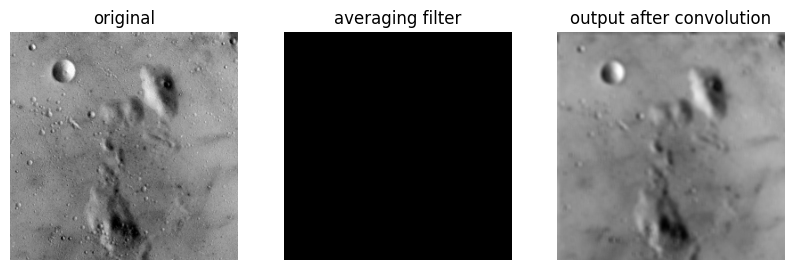

In [4]:
image1 = plt.imread('./Images/5.1.09.tiff')
averaging_filter_5x5 = np.ones((5, 5))
averaging_filter_5x5 /= averaging_filter_5x5.sum()
output = Convolutions.circular_convolution(image1, averaging_filter_5x5)

SmartPlot().plot_multi_images(images=[
    image1, averaging_filter_5x5, output
                            ],
                            titles=['original', 'averaging filter', 'output after convolution'],
                            axis='off',
                            figsize=(10, 3),
                            cmaps='gray')
                            


In [5]:
dft_img = matrix_DFT(image1)
filter = np.zeros_like(image1, dtype=float)
filter[:5, :5] = averaging_filter_5x5
dft_filter = matrix_DFT(filter)
idft = matrix_IDFT(dft_filter * dft_img).real

print(np.linalg.norm(idft-output))

1.7554128688017173e-08


From the above we can conclude that the IDFT of the product of the image and filter DFT does indeed result in circular convolution.

## Subpart-2

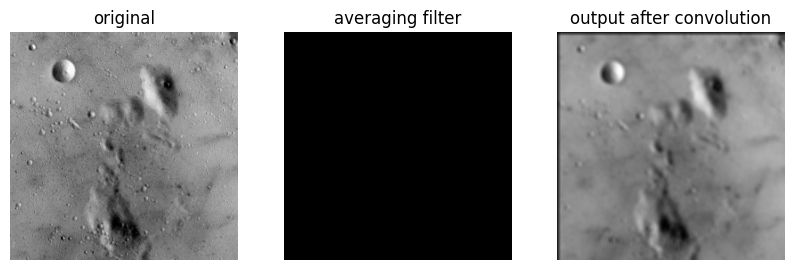

In [6]:
output = Convolutions.linear_convolution(image1, averaging_filter_5x5)

SmartPlot().plot_multi_images(images=[
    image1, averaging_filter_5x5, output
                            ],
                            titles=['original', 'averaging filter', 'output after convolution'],
                            axis='off',
                            figsize=(10, 3),
                            cmaps='gray')
                            


## Subpart-3

In [7]:
def pad_images_DFT(image1, image2):
    n, m = image1.shape
    out1 = np.zeros((2*n, 2*m))
    out2 = np.zeros_like(out1)
    out1[:n, :m] = image1
    n2, m2 = image2.shape
    out2[:n2, :m2] = image2
    return out1, out2

def linear_convolution_fourier(image1, image2):
    padded_image1, padded_image2 = pad_images_DFT(image1, image2)
    dft1 = matrix_DFT(padded_image1)
    dft2 = matrix_DFT(padded_image2)
    n, m = image1.shape
    return matrix_IDFT(dft1 * dft2).real[:n, :m]


image_sizes = [16, 32, 64, 128]
filter_sizes = [1, 3, 5, 7]

import time

for filter_size in filter_sizes:
    filter = np.ones((filter_size, filter_size))
    filter /= filter.sum()
    for image_size in image_sizes:
        img = image1[:image_size, :image_size]
        start = time.time()
        out1 = Convolutions.linear_convolution(img, filter)
        end = time.time()
        out2 = linear_convolution_fourier(img, filter)
        next_end = time.time()
        spatial_time = end - start
        fourier_time = next_end - end
        print(f'filter size: {filter_size} x {filter_size}')
        print(f'Image Size: {image_size} x {image_size}')
        print(f'Spatial: {spatial_time}s')
        print(f'Fourier: {fourier_time}s')
        print(f'Speedup: {spatial_time/fourier_time}')
        print(f'MSE: {np.linalg.norm(out1-out2)}')
        print('-'*20)

        



filter size: 1 x 1
Image Size: 16 x 16
Spatial: 0.002735137939453125s
Fourier: 0.0012364387512207031s
Speedup: 2.2121095256459697
MSE: 1.7907171274235445e-11
--------------------
filter size: 1 x 1
Image Size: 32 x 32
Spatial: 0.011124610900878906s
Fourier: 0.0014145374298095703s
Speedup: 7.864486768919602
MSE: 2.7526416944583216e-10
--------------------
filter size: 1 x 1
Image Size: 64 x 64
Spatial: 0.07045221328735352s
Fourier: 0.013672113418579102s
Speedup: 5.152986310925103
MSE: 8.621930771912316e-10
--------------------
filter size: 1 x 1
Image Size: 128 x 128
Spatial: 0.21452546119689941s
Fourier: 0.08967733383178711s
Speedup: 2.392192676014399
MSE: 8.247189349836972e-09
--------------------
filter size: 3 x 3
Image Size: 16 x 16
Spatial: 0.031789302825927734s
Fourier: 0.0014302730560302734s
Speedup: 22.22603767294549
MSE: 1.6639327472130285e-11
--------------------
filter size: 3 x 3
Image Size: 32 x 32
Spatial: 0.10350513458251953s
Fourier: 0.0013439655303955078s
Speedup: 77.0

Convolving in fourier domain is turning out to be faster always because of vectorized implementation. 

From the speed up factors, we can observer that if the filter size is small then convolving is spatial domain is not much worse than in fourier domain, but as the filter size increases, convolving in spatial domain becomes much more expensive.

# Question-2

## Subpart-1

The filter parameter in the averaging filter is the size of the filter.

In [8]:
def convolution(img : np.ndarray, kernel : np.ndarray, stride : int = 1, mode=None) -> np.ndarray:
    """
    Parameters
    ---------
    Returns the convoluted image"""    
    # kernel and image sizes
    kernel_size = kernel.shape
    img_size = img.shape

    # dimensions of image
    W, H = img_size[:2]
    # dimension of kernel
    k = kernel_size[0]
    assert kernel_size[0] == kernel_size[1], "kernel should be a k x k matrix"



    padding = k >> 1
    
    # flipped images
    horizontal_flipped = img[::-1]
    vertical_flipped = img[:,::-1]
    fully_flipped = img[::-1,::-1]

    # creating padded image
    if padding:
        padded_array = np.zeros((W+2*padding, H+2*padding))
        padded_array[padding:-padding,padding:-padding] = img.copy()
        if mode == 'reflect':
            padded_array[:padding,:padding] = fully_flipped[-padding:,-padding:]
            padded_array[-padding:,-padding:] = fully_flipped[:padding,:padding]
            padded_array[:padding,-padding:] = fully_flipped[-padding:,:padding]
            padded_array[-padding:,:padding] = fully_flipped[:padding,-padding:]
            padded_array[:padding,padding:-padding] = horizontal_flipped[-padding:,:]
            padded_array[-padding:,padding:-padding] = horizontal_flipped[:padding,:]
            padded_array[padding:-padding,:padding] = vertical_flipped[:,-padding:]
            padded_array[padding:-padding,-padding:] = vertical_flipped[:,:padding]
    else:
        padded_array = img.copy()
        
    output = np.zeros(( 1+(W+2*padding-k)//stride, 1+(H+2*padding-k)//stride ))
    x,y = 0,0
    for i in range(0, W+1+2*padding-k, stride):
        for j in range(0, H+1+2*padding-k, stride):
            output[x,y] = np.sum(padded_array[i:i+k,j:j+k]*kernel)
            y += 1
            
        x += 1
        y = 0
        
    return output

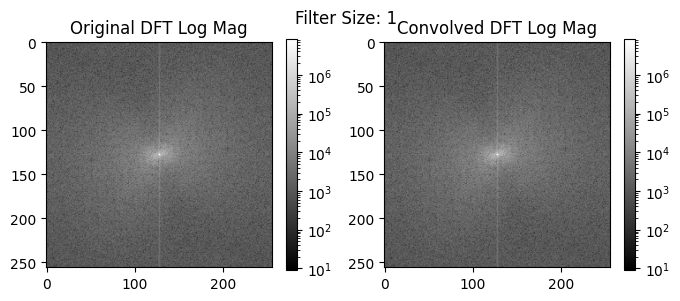

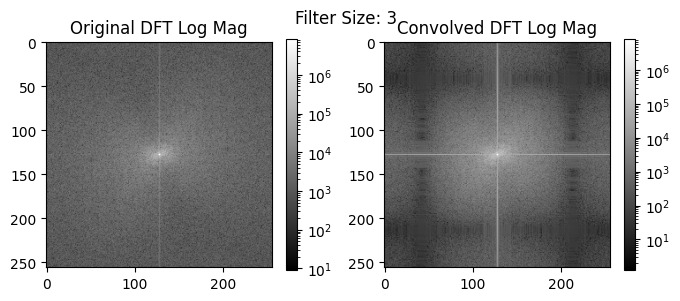

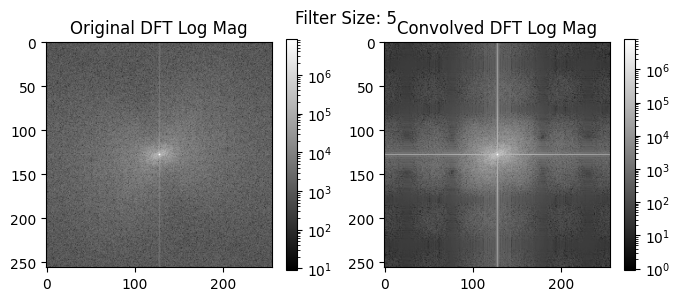

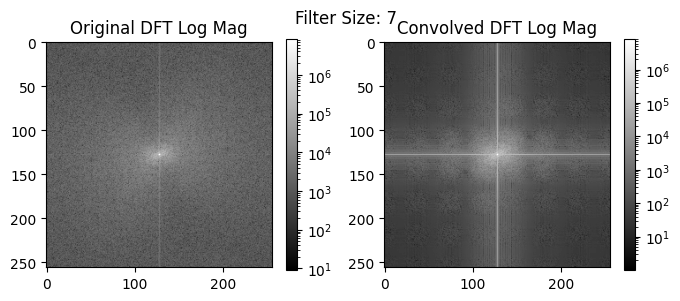

In [9]:
import matplotlib.colors as mc

def centered_DFT(image):
    image = image.astype(complex)
    n, m = image.shape
    r = np.arange(m)
    c = np.arange(n)
    mat = c[:, None] + r[None, :]
    p = np.power(-1, mat)
    image *= p
    return matrix_DFT(image)


for filter_size in filter_sizes:
    filter = np.ones((filter_size, filter_size))
    filter /= filter.sum()

    dft1 = np.abs(centered_DFT(image1))
    out = linear_convolution_fourier(image1, filter)
    dft2 = np.abs(centered_DFT(out))

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
    ax[0].set_title(f'Original DFT Log Mag')
    plt.colorbar(t)
    t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
    ax[1].set_title(f'Convolved DFT Log Mag')
    plt.colorbar(t)
    fig.suptitle(f'Filter Size: {filter_size}')
    plt.show()    

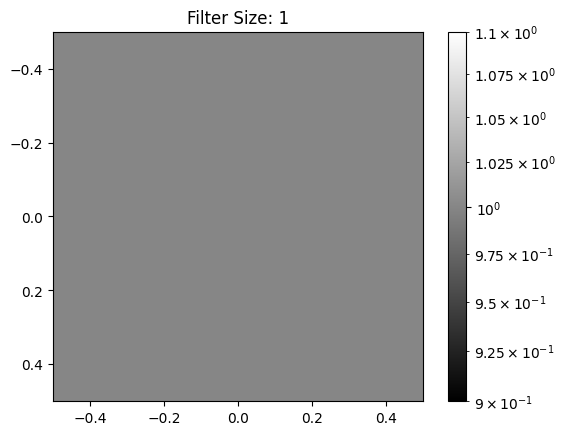

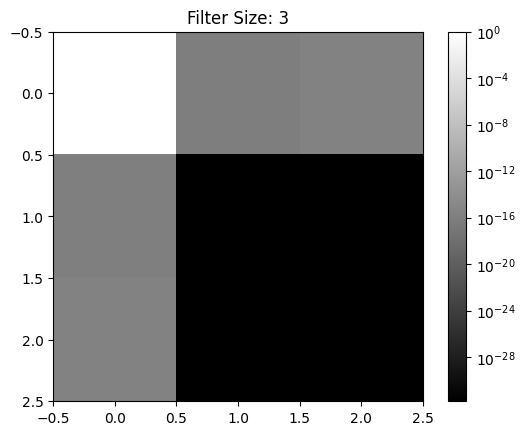

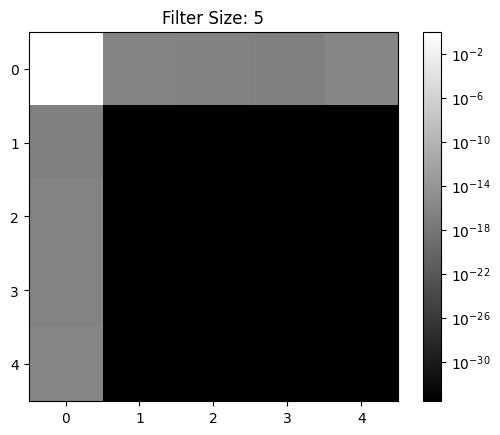

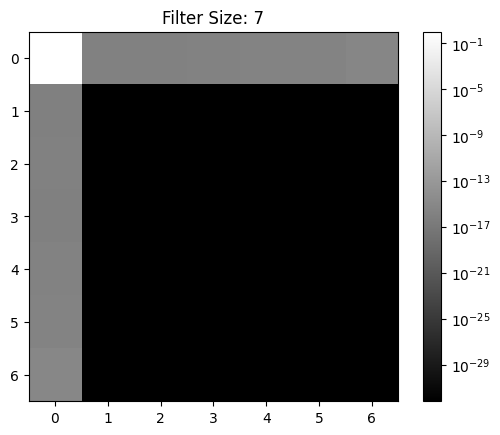

In [15]:
for filter_size in filter_sizes:
    filter = np.ones((filter_size, filter_size))
    filter /= filter.sum()
    dft = matrix_DFT(filter)
    plt.imshow(np.abs(dft), norm=mc.LogNorm(), cmap='gray')
    plt.colorbar()
    plt.title(f'Filter Size: {filter_size}')
    plt.show()

We can clearly see that it is a low pass filter from the magnitude plots above. As the filter size increases, it allows fewer high frequenies.

## Subpart-2

The parameters for guassian filter are sigma, filter size but the two are actually dependent as we will see

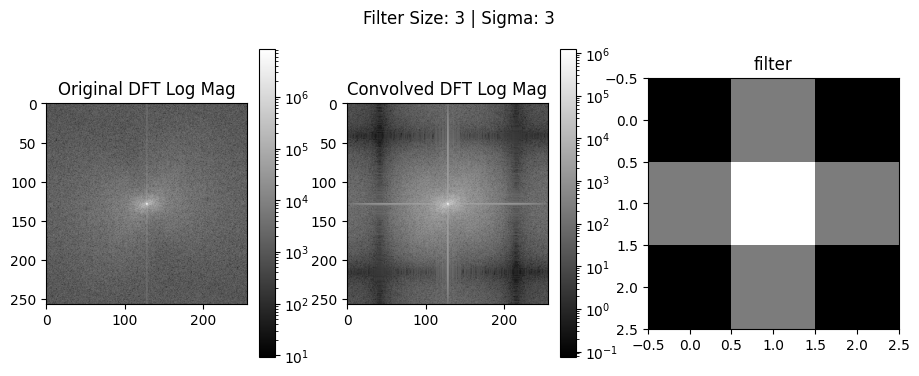

In [16]:
def gaussian_filter(sigma, filter_size):
    # we can write the gaussian filter as a gram matrix
    # this is because it can be separated as a function of
    # u and v
    vec = np.arange(-(filter_size-1)/2, (filter_size+1)/2)
    vec = np.exp(-0.5 * np.square(vec) / (sigma**2))

    filter = vec[:,None] @ vec[None,:]
    filter /= 2 * np.pi * np.square(sigma)
    return filter



sigma = 3
filter_size = 3

filter = gaussian_filter(sigma, filter_size)

dft1 = np.abs(centered_DFT(image1))
out = convolution(image1, filter)
dft2 = np.abs(centered_DFT(out))

fig, ax = plt.subplots(1, 3, figsize=(11, 4))
t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
ax[0].set_title(f'Original DFT Log Mag')
plt.colorbar(t)
t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
ax[1].set_title(f'Convolved DFT Log Mag')
plt.colorbar(t)
ax[2].imshow(filter, cmap='gray')
ax[2].set_title('filter')
fig.suptitle(f'Filter Size: {filter_size} | Sigma: {sigma}')
plt.show()

    

Notice the black plus signs near each corner. They are there because we cropped the filter even when it had large values outside the cropped region.

We will use the heuristic

$\text{filter\_size} = 6*\sigma + 1$

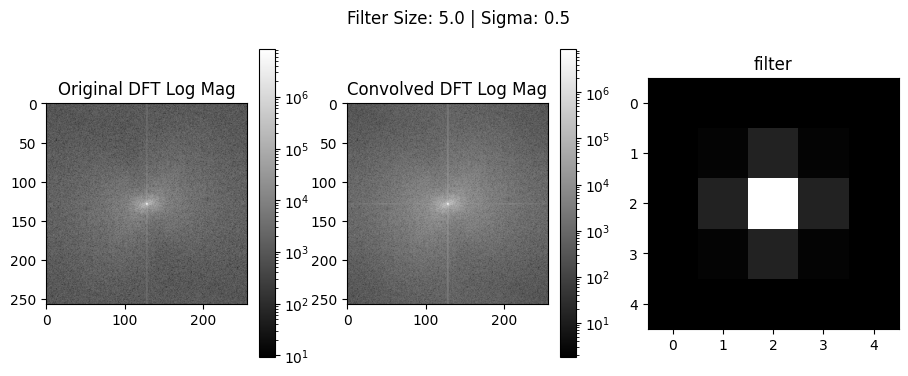

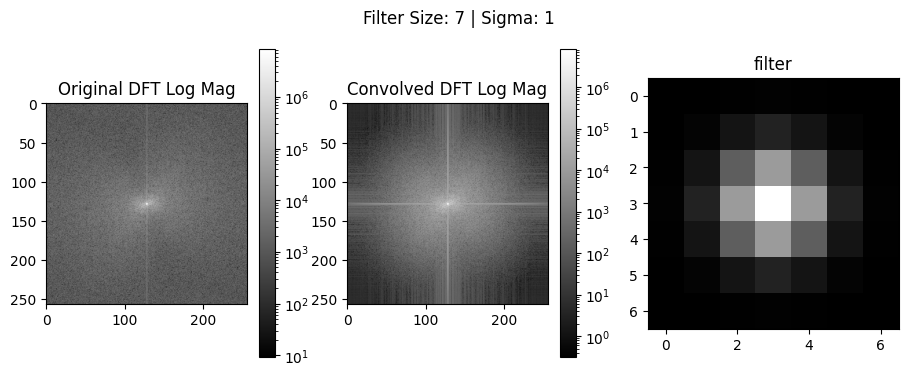

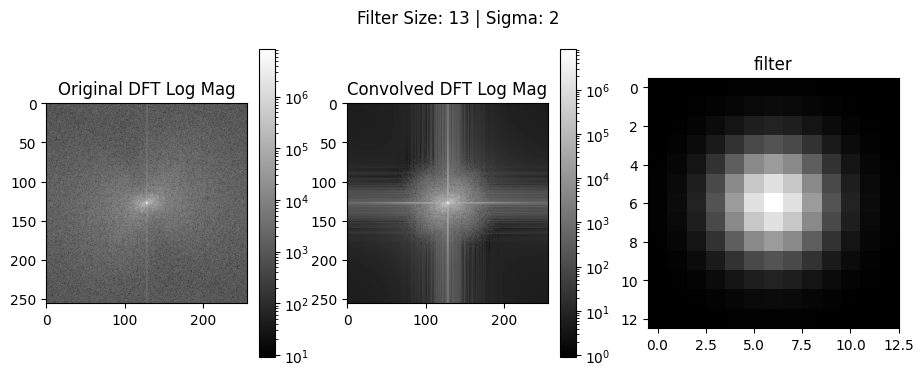

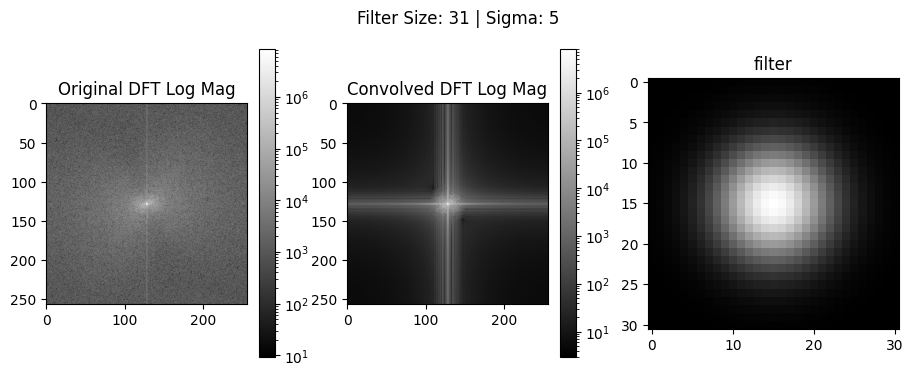

In [17]:
sigmas = [0.5, 1, 2, 5]

for sigma in sigmas:
    filter_size = np.round(6*sigma+1)
    if filter_size % 2 == 0:
        filter_size += 1 # making the filter size odd
    filter = gaussian_filter(sigma, filter_size)

    dft1 = np.abs(centered_DFT(image1))
    # out = linear_convolution_fourier(image1, filter)
    out = convolution(image1, filter)
    dft2 = np.abs(centered_DFT(out))

    fig, ax = plt.subplots(1, 3, figsize=(11, 4))
    t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
    ax[0].set_title(f'Original DFT Log Mag')
    plt.colorbar(t)
    t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
    ax[1].set_title(f'Convolved DFT Log Mag')
    plt.colorbar(t)
    ax[2].imshow(filter, cmap='gray')
    ax[2].set_title('filter')
    fig.suptitle(f'Filter Size: {filter_size} | Sigma: {sigma}')
    plt.show()



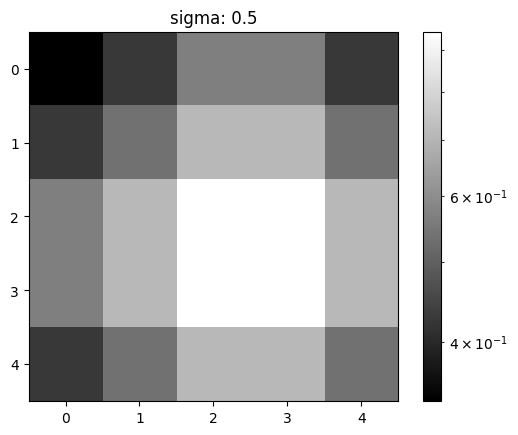

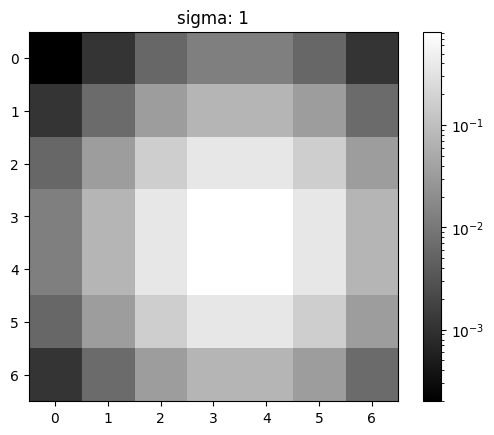

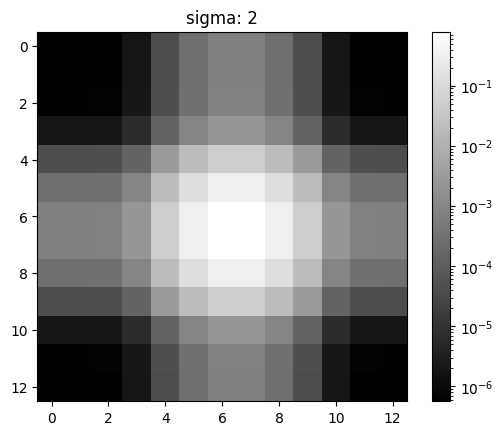

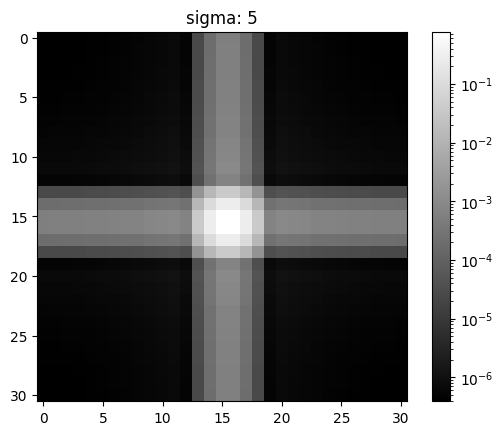

In [27]:
for sigma in sigmas:
    filter_size = math.ceil(6*sigma+1)
    if not filter_size & 1:
        filter_size += 1

    filter = gaussian_filter(sigma, filter_size)
    dft = centered_DFT(filter)
    plt.imshow(np.abs(dft), norm=mc.LogNorm(), cmap='gray')
    plt.colorbar()
    plt.title(f'sigma: {sigma}')
    plt.show()

As sigma and filter size increases, it allows fewer high frequencies.

## Subpart-3

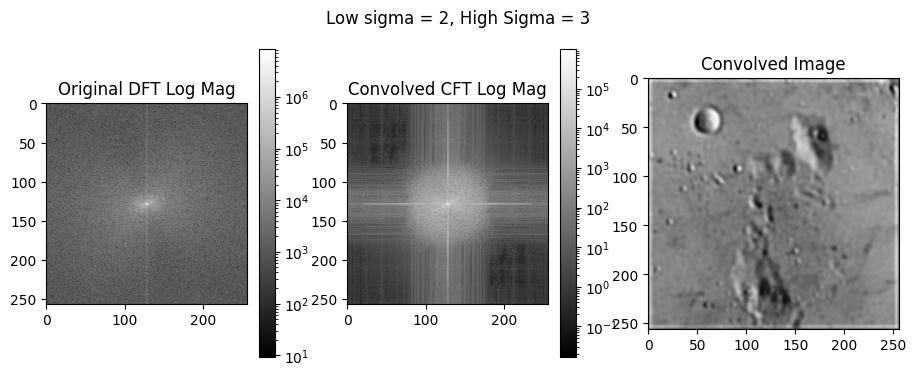

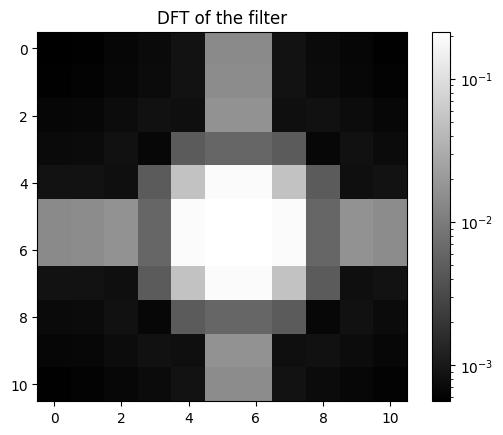

In [30]:
filter = gaussian_filter(filter_size=11, sigma=2) - gaussian_filter(filter_size=11, sigma=3)

dft1 = np.abs(centered_DFT(image1))
out = convolution(image1, filter)
dft2 = np.abs(centered_DFT(out))

fig, ax = plt.subplots(1, 3, figsize=(11, 4))
t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
ax[0].set_title(f'Original DFT Log Mag')
plt.colorbar(t)
t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
ax[1].set_title(f'Convolved CFT Log Mag')
plt.colorbar(t)
ax[2].imshow(out, cmap='gray')
ax[2].set_title('Convolved Image')
fig.suptitle('Low sigma = 2, High Sigma = 3')
plt.show()


dft = centered_DFT(filter)
plt.imshow(np.abs(dft), norm=mc.LogNorm(), cmap='gray')
plt.colorbar()
plt.title(f'DFT of the filter')
plt.show()

We can see that the frequency response corresponds to that of a band pass filter

## Subpart-4

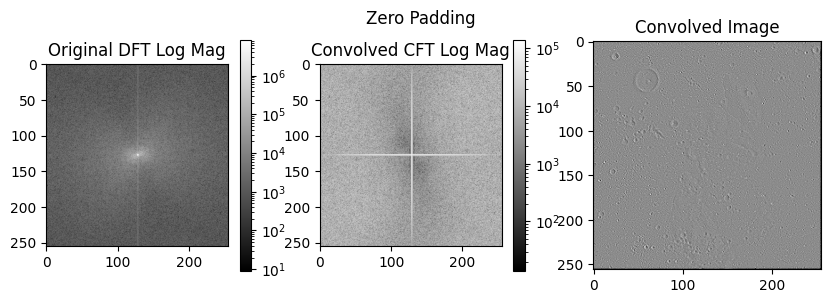

In [253]:
laplacian_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
dft1 = np.abs(centered_DFT(image1))
out = convolution(image1, laplacian_filter)
dft2 = np.abs(centered_DFT(out))

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
ax[0].set_title(f'Original DFT Log Mag')
plt.colorbar(t)
t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
ax[1].set_title(f'Convolved CFT Log Mag')
plt.colorbar(t)
ax[2].imshow(out, cmap='gray')
ax[2].set_title('Convolved Image')
fig.suptitle('Zero Padding')
plt.show()


The reason why it doesn't look like a high pass filter is because of 0 padding. We can use either circular convolution or even reflective padding to solve the issue.

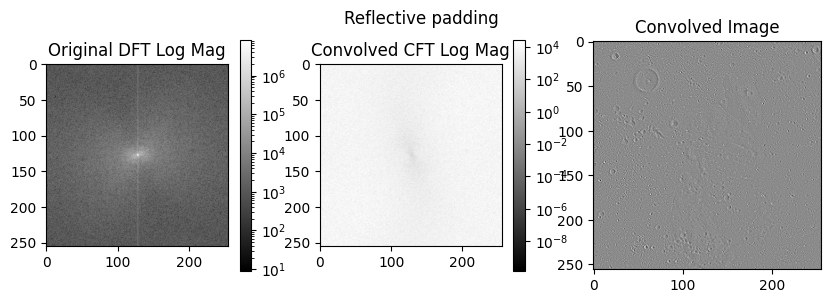

In [254]:
laplacian_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
dft1 = np.abs(centered_DFT(image1))
out = convolution(image1, laplacian_filter, mode='reflect')
dft2 = np.abs(centered_DFT(out))

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
ax[0].set_title(f'Original DFT Log Mag')
plt.colorbar(t)
t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
ax[1].set_title(f'Convolved CFT Log Mag')
plt.colorbar(t)
ax[2].imshow(out, cmap='gray')
ax[2].set_title('Convolved Image')
fig.suptitle('Reflective padding')
plt.show()


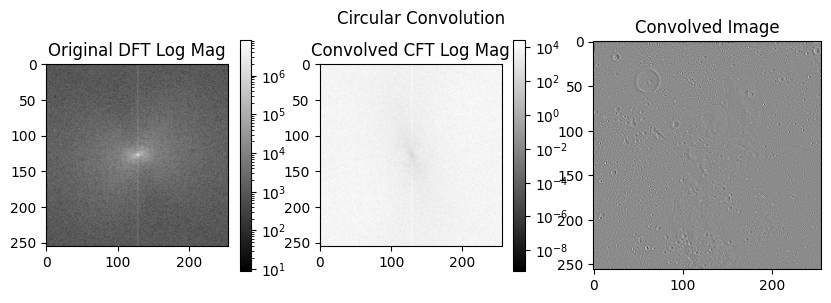

In [256]:
laplacian_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
dft1 = np.abs(centered_DFT(image1))
out = Convolutions.circular_convolution(image1, laplacian_filter)
dft2 = np.abs(centered_DFT(out))

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
t = ax[0].imshow(dft1, norm=mc.LogNorm(), cmap='gray')
ax[0].set_title(f'Original DFT Log Mag')
plt.colorbar(t)
t = ax[1].imshow(dft2, norm=mc.LogNorm(), cmap='gray')
ax[1].set_title(f'Convolved CFT Log Mag')
plt.colorbar(t)
ax[2].imshow(out, cmap='gray')
ax[2].set_title('Convolved Image')
fig.suptitle('Circular Convolution')
plt.show()


# Question-3

## Subpart-1

### Subsubpart-a

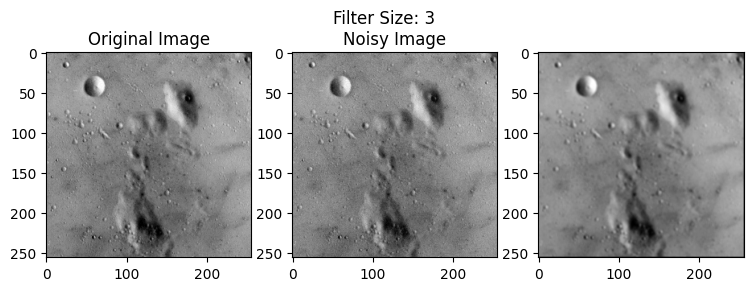

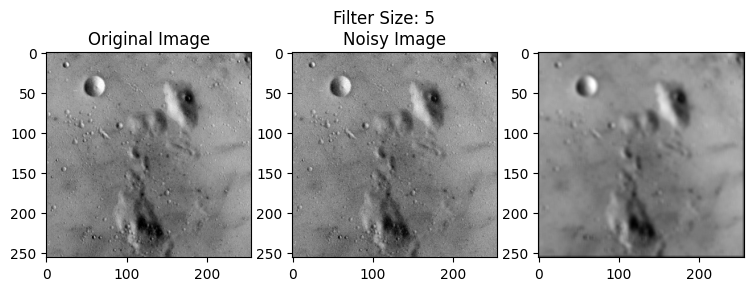

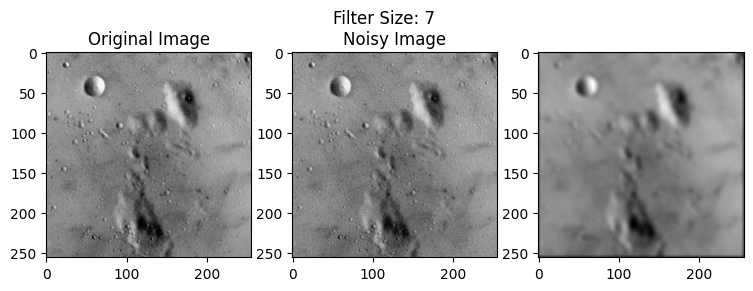

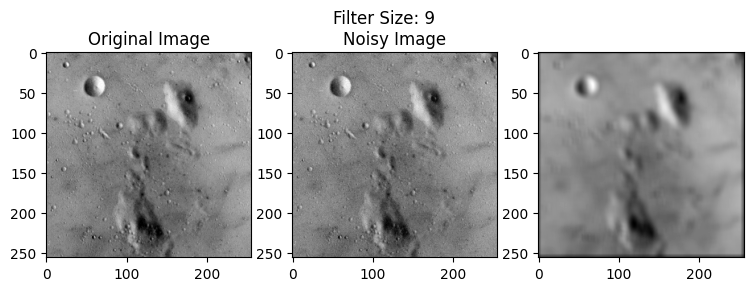

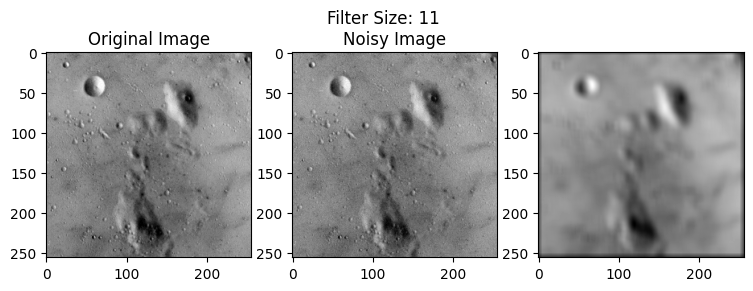

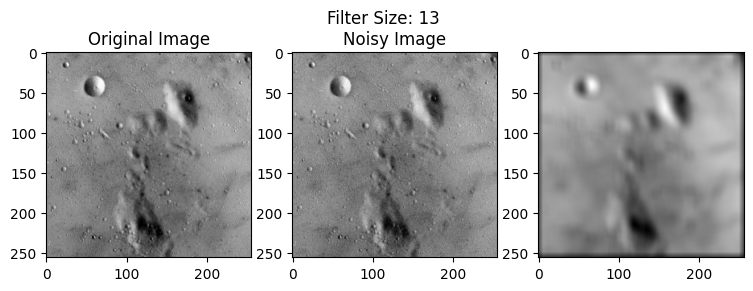

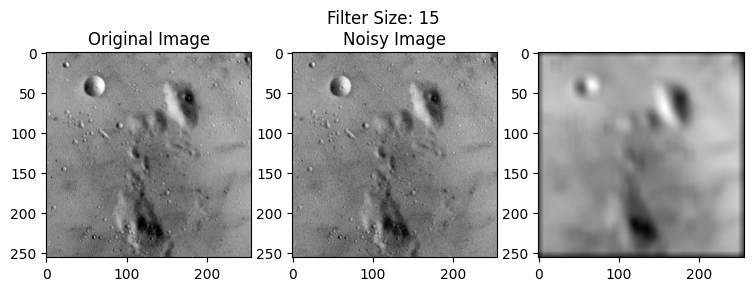

In [301]:
noisy_image = image1 + np.random.normal(loc=0, scale=5, size=image1.shape)

for ksize in range(3, 17, 2):
    filter = np.ones((ksize, ksize))
    filter /= filter.sum()
    out = convolution(image1, filter)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(noisy_image, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[2].imshow(out, cmap='gray')

    fig.suptitle(f'Filter Size: {ksize}')
    plt.show()

    

The noise doesn't appear visually significant in this image, the filters with size 3 and 5 seem fine, beyond that size there's a lot of blurring.

## Subsubpart-b

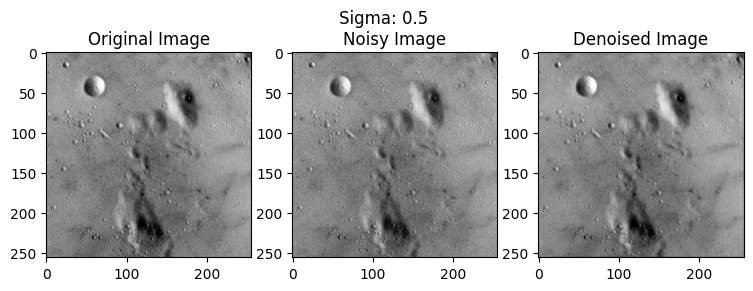

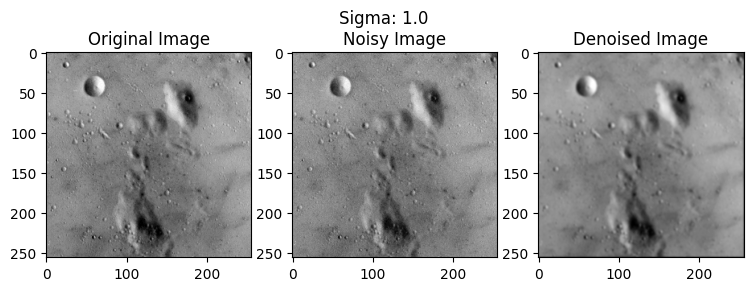

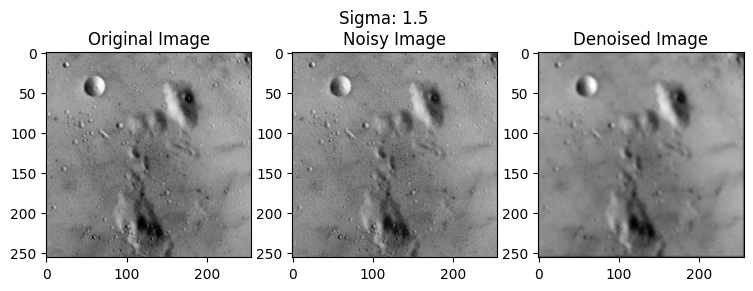

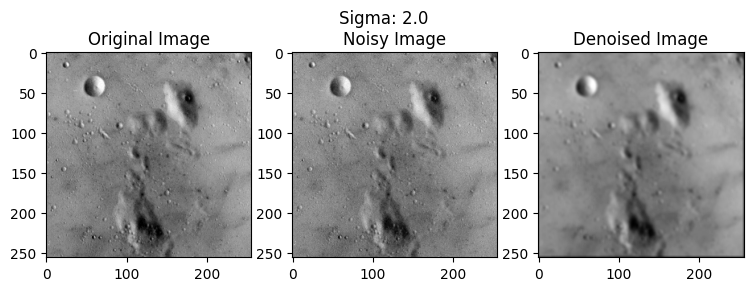

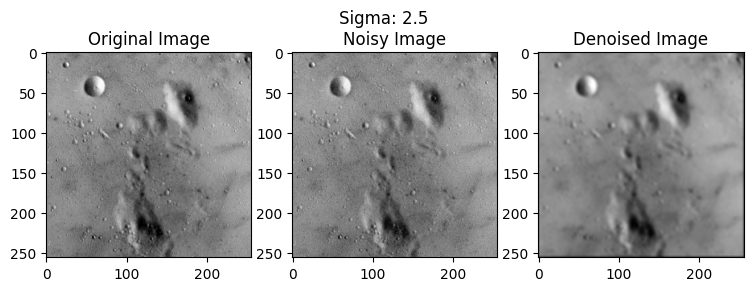

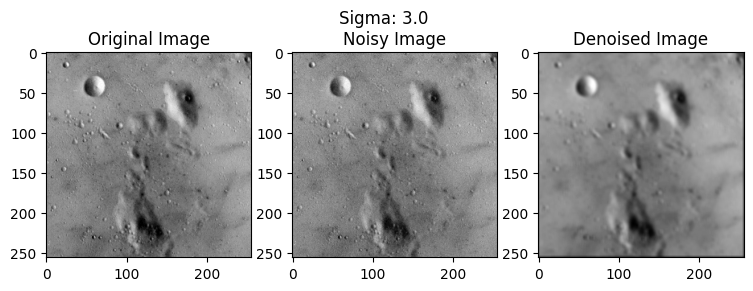

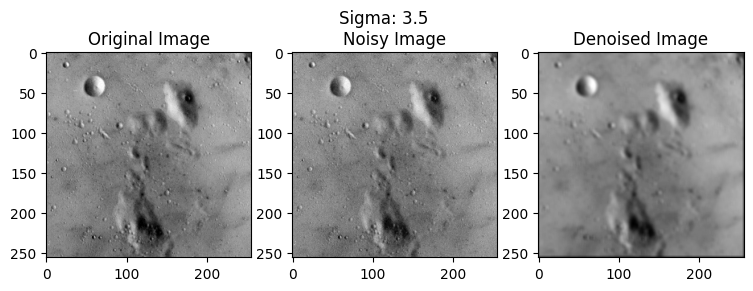

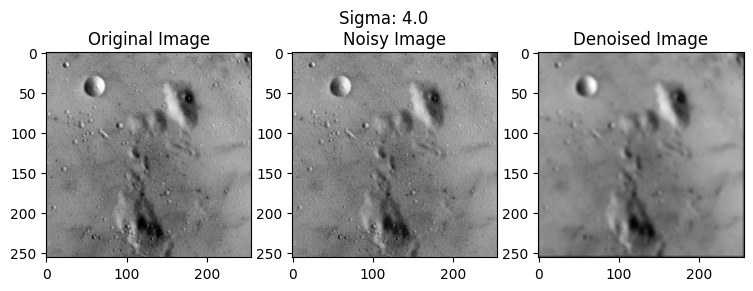

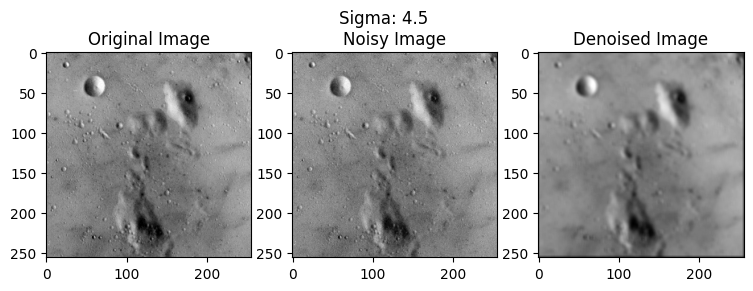

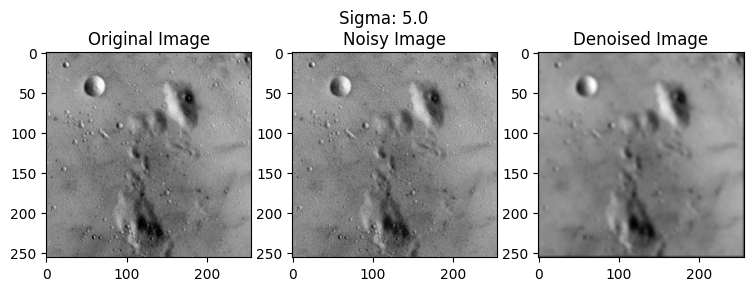

In [302]:
noisy_image = image1 + np.random.normal(loc=0, scale=5, size=image1.shape)

for sigma in np.arange(0.5, 5.5, 0.5):
    filter = gaussian_filter(sigma, 5)
    out = convolution(image1, filter)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(noisy_image, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[2].imshow(out, cmap='gray')
    ax[2].set_title('Denoised Image')

    fig.suptitle(f'Sigma: {sigma}')
    plt.show()

    

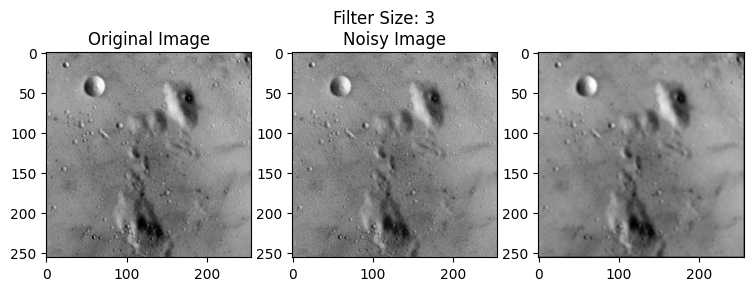

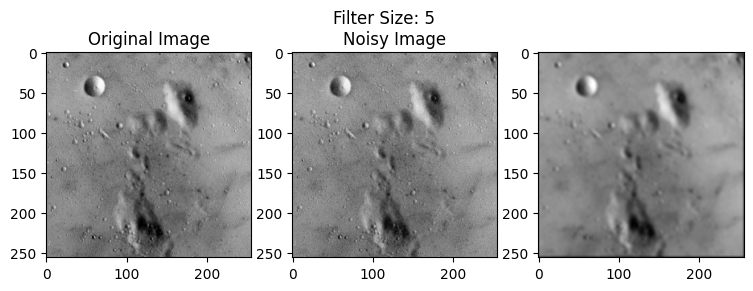

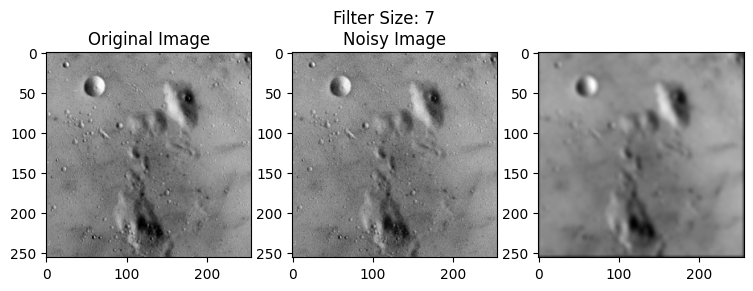

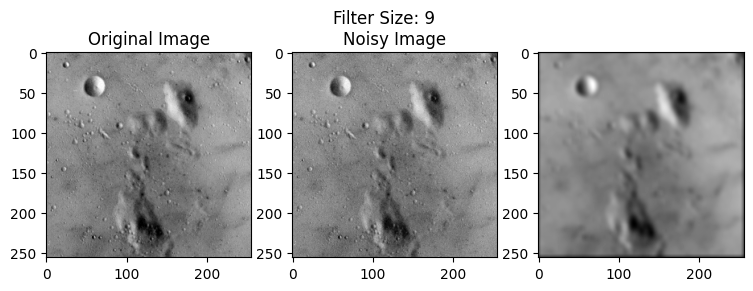

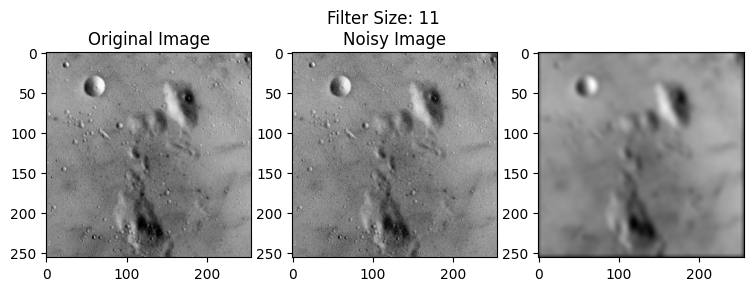

In [303]:
sigma = 3
for ksize in range(3, 13, 2):
    filter = gaussian_filter(sigma, ksize)
    out = convolution(image1, filter)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(noisy_image, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[2].imshow(out, cmap='gray')

    fig.suptitle(f'Filter Size: {ksize}')
    plt.show()

    

When we increase the filter size the blurring increases, this is because some values we are averaging with more values. Beyond a certain point, it stops changing much because the values in the outer regions of the filter are close to 0, we only see the thicker black edges because of zero padding

## Subpart-2

In [311]:
mandrill = plt.imread('./Images/4.2.03.tiff').sum(axis=-1).astype(float) # converting to single channel


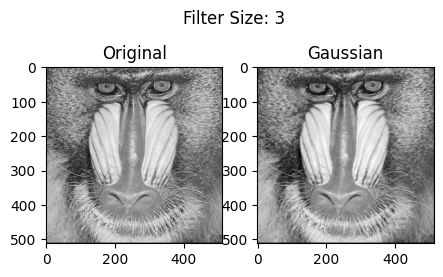

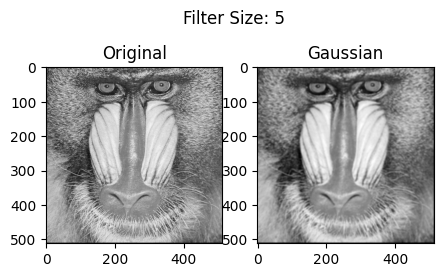

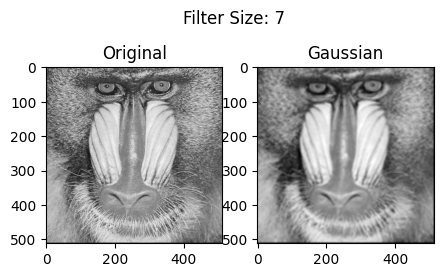

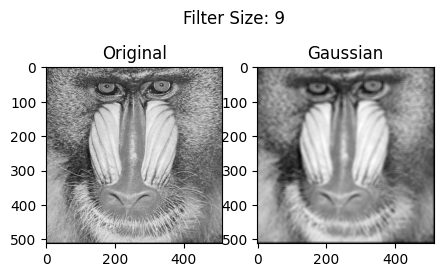

In [335]:
# Mean Filter
for ksize in range(3, 11, 2):
    filter = np.ones((ksize, ksize))
    filter /= filter.sum()
    out = convolution(mandrill, filter)

    SmartPlot.plot_multi_images([mandrill, out], titles=['Original', "Gaussian"], cmaps='gray', figsize=(5, 3), suptitle=f'Filter Size: {ksize}')

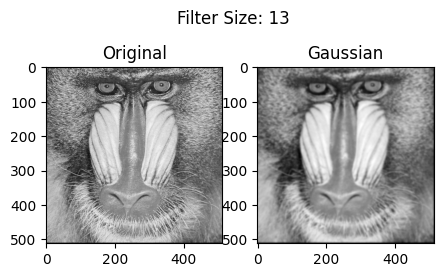

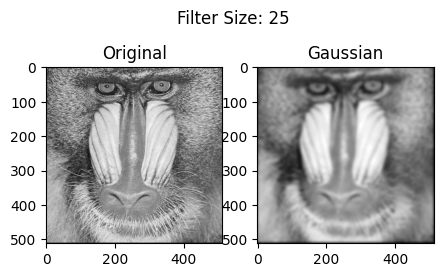

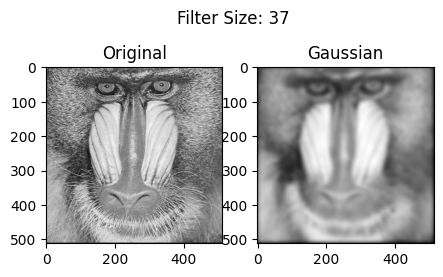

In [333]:
# Gasusian
for sigma in range(2, 7, 2):
    ksize = 6*sigma + 1
    if not ksize & 1:
        ksize += 1
    filter = gaussian_filter(sigma, ksize)
    out = convolution(mandrill, filter)

    SmartPlot.plot_multi_images([mandrill, out], titles=['Original', "Gaussian"], cmaps='gray', figsize=(5, 3), suptitle=f'Filter Size: {ksize}')

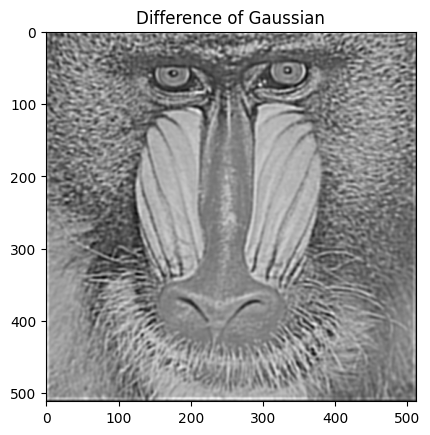

In [336]:
# Difference of Gaussian
filter = gaussian_filter(2, 11) - gaussian_filter(3, 11)
out = convolution(mandrill, filter)

plt.imshow(out, cmap='gray')
plt.title('Difference of Gaussian')
plt.show()

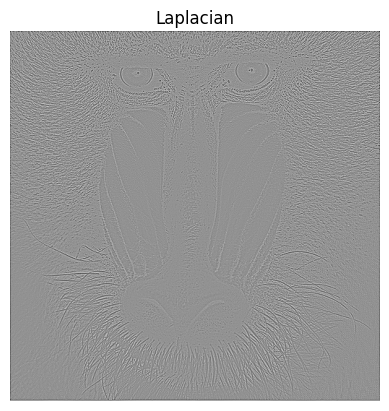

In [337]:
# Laplace
out = convolution(mandrill, laplacian_filter)
plt.imshow(out, cmap='gray')
plt.title('Laplacian')
plt.axis('off')
plt.show()

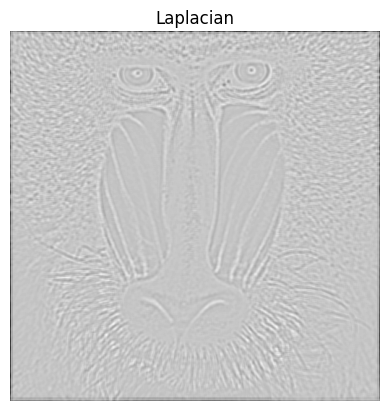

In [338]:
# Laplacian of Gaussian
out_mid = convolution(mandrill, gaussian_filter(2, 7))
out = convolution(out_mid, laplacian_filter)
plt.imshow(out, cmap='gray')
plt.title('Laplacian')
plt.axis('off')
plt.show()

Observations
1. Using just mean filters or gaussian filters we don't observe much. It just causes blurring.
2. Using difference of gaussian also doesn't result in anything interesting. 
3. Using Laplacian Filter, we are able to observe the edges but they are not very clear.
4. Using Laplacian of gaussian makes the edges appear more distinct.